### import

In [2]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np

# Display and Image handling
from IPython.display import display
from PIL import Image as PILImage  # 使用 PILImage 作为 PIL.Image 的别名
from IPython.display import Image as IPyImage  # 使用 IPyImage 作为 IPython 的 Image

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch

# LLM
import ollama

# PDF处理
import PyPDF2

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 检查并创建必要的目录
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

/Users/zirong/miniforge3/envs/llm/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
import sys
import torch
import transformers
import accelerate
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Python version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:55:20) 
[Clang 16.0.6 ]
PyTorch version: 2.5.1
Transformers version: 4.47.0
Accelerate version: 0.26.0


### voice to text


In [4]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

### 圖片處理

In [5]:
from typing import Union  # 添加 Union 导入

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [6]:
%matplotlib inline
# from IPython.display import display, Image
class HybridEmbeddingProcessor:
    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224)):
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir)
        
        # 初始化模型
        self.text_model = SentenceTransformer('all-mpnet-base-v2')
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # 获取CLIP模型的输出维度
        with torch.no_grad():
            dummy_image = torch.zeros((1, 3, 224, 224))
            image_features = self.clip_model.get_image_features(dummy_image)
            self.image_dimension = image_features.shape[1]  # 应该是 512

        # 设置 Chroma
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)
        
        # 使用 SentenceTransformer embedding function
        sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name='all-mpnet-base-v2',
            device="cpu"
        )
        
        try:
            # 删除现有的集合
            collections_to_delete = ["questions", "answers", "image_documents"]
            for collection_name in collections_to_delete:
                try:
                    self.chroma_client.delete_collection(collection_name)
                    logger.info(f"Deleted collection: {collection_name}")
                except Exception as e:
                    # pass
                    logger.info(f"Collection {collection_name} does not exist or could not be deleted: {str(e)}")
            
            # 创建新的集合
            # 创建新的集合，指定维度
            sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
                model_name='all-mpnet-base-v2'
            )

            self.question_collection = self.chroma_client.create_collection(
                name="questions",
                embedding_function=sentence_transformer_ef
            )
            
            self.answer_collection = self.chroma_client.create_collection(
                name="answers",
                embedding_function=sentence_transformer_ef
            )
            
            self.image_collection = self.chroma_client.create_collection(
                name="image_documents",
                metadata={"dimension": self.image_dimension}
            )
            logger.info(f"Created collections with image dimension: {self.image_dimension}")

            
        except Exception as e:
            logger.error(f"Error initializing collections: {str(e)}")
            raise

    def add_qa_pairs(self,
                questions: List[str],
                answers: List[str],
                question_metadatas: List[Dict],
                answer_metadatas: List[Dict],
                images: Optional[List[str]] = None):
        """添加问答对到不同的集合"""
        try:
            # 添加问题
            if questions and question_metadatas:
                logger.info(f"Adding {len(questions)} questions")
                self.question_collection.add(
                    documents=questions,
                    metadatas=question_metadatas,
                    ids=[f"q_{i}" for i in range(len(questions))]
                )
            
            # 添加回答
            if answers and answer_metadatas:
                logger.info(f"Adding {len(answers)} answers")
                self.answer_collection.add(
                    documents=answers,
                    metadatas=answer_metadatas,
                    ids=[f"a_{i}" for i in range(len(answers))]
                )
            
            # 处理图片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_qa_id": f"q_{i}" if i < len(questions) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
            
        except Exception as e:
            logger.error(f"Error adding QA pairs: {str(e)}")
            raise

    def process_image(self, image_path: str) -> Optional[np.ndarray]:
            """處理圖片並生成 embedding"""
            try:
                logger.info(f"Processing image: {image_path}")
                processed_path = self.image_processor.process_and_save(
                    image_path=image_path,
                    target_size=self.image_size
                )
                
                if processed_path is None:
                    logger.error(f"Failed to process image: {image_path}")
                    return None
                    
                image = PILImage.open(processed_path)
                inputs = self.clip_processor(images=image, return_tensors="pt")
                image_features = self.clip_model.get_image_features(**inputs)
                
                logger.info(f"Successfully generated embedding for image: {image_path}")
                return image_features.detach().numpy()[0]
                
            except Exception as e:
                logger.error(f"Error processing image {image_path}: {str(e)}")
                return None

    def add_documents(self, 
                     texts: List[str], 
                     metadatas: List[Dict],
                     images: Optional[List[str]] = None):
        """添加文件到不同的集合"""
        try:
            # 添加文本文件
            if texts and metadatas:
                logger.info(f"Adding {len(texts)} text documents")
                self.text_collection.add(
                    documents=texts,
                    metadatas=metadatas,
                    ids=[f"text_{i}" for i in range(len(texts))]
                )
                logger.info("Successfully added text documents")
            
            # 處理並添加圖片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    logger.info(f"Processing image {i+1}/{len(images)}: {img_path}")
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_text": texts[i] if i < len(texts) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
                    logger.info("Successfully added images to collection")
                else:
                    logger.warning("No valid images to add to collection")
        
        except Exception as e:
            logger.error(f"Error adding documents: {str(e)}", exc_info=True)
            raise
    
    def process_text(self, text: str) -> np.ndarray:
        """使用 SentenceTransformer 處理文本"""
        try:
            embedding = self.text_model.encode(text)
            return embedding
        except Exception as e:
            logger.error(f"Error processing text: {str(e)}")
            return None
        
    def search(self, query: str, k: int = 3) -> Dict:
        """整合社群和专业知识的搜索方法"""
        try:
            logger.info("Starting search operation...")
            
            # 1. 搜索社群问答
            social_results = self.question_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 2. 搜索专业文献
            professional_results = self.answer_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 3. 整合结果并标记来源
            combined_results = {
                "social": {
                    "questions": social_results["documents"][0] if social_results["documents"] else [],
                    "answers": social_results["answers"] if "answers" in social_results else [],
                    "metadata": social_results["metadatas"][0] if social_results["metadatas"] else [],
                    "relevance": social_results["distances"][0] if social_results["distances"] else []
                },
                "professional": {
                    "content": professional_results["documents"][0] if professional_results["documents"] else [],
                    "metadata": professional_results["metadatas"][0] if professional_results["metadatas"] else [],
                    "relevance": professional_results["distances"][0] if professional_results["distances"] else []
                }
            }
            
            # 4. 搜索相关图片
            image_results = self._search_images(query, k)
            combined_results["images"] = image_results

            return combined_results
                
        except Exception as e:
            logger.error(f"Search error: {str(e)}")
            return {
                "social": {"questions": [], "answers": [], "metadata": [], "relevance": []},
                "professional": {"content": [], "metadata": [], "relevance": []},
                "images": {"metadata": [], "paths": [], "relevance": []}
            }
    def _search_images(self, query: str, k: int = 3) -> Dict:
        """Search for relevant images"""
        try:
            # Use the image collection to search for similar images
            image_results = self.image_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            return {
                "metadata": image_results.get("metadatas", []),
                "paths": image_results.get("ids", []),
                "relevance": image_results.get("distances", [])
            }
        except Exception as e:
            logger.error(f"Error searching images: {str(e)}")
            return {
                "metadata": [],
                "paths": [],
                "relevance": []
            }

### 資料處理模組

In [7]:
class DataProcessor:
    def __init__(self, embedding_processor: 'HybridEmbeddingProcessor'):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[Dict], List[str]]:
        """处理 CSV 并提取问答对和图片"""
        logger.info(f"Processing CSV: {csv_path}")
        qa_pairs = []
        images = []
        
        df = pd.read_csv(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_link = None
        
        for _, row in df.iterrows():
            # 处理新的帖子
            if pd.notna(row['post']):
                # 保存前一个问答对
                if current_post is not None:
                    qa_pair = {
                        'question': current_post,
                        'answers': current_responses.copy(),
                        'images': current_images.copy(),
                        'link': current_link,
                        'metadata': {
                            'type': 'social_qa',
                            'source': 'facebook',
                            'images': ','.join(current_images) if current_images else '',
                            'answer_count': len(current_responses)
                        }
                    }
                    qa_pairs.append(qa_pair)
                    if current_images:
                        images.extend(current_images)
                
                # 初始化新的问答对
                current_post = row['post']
                current_responses = []
                current_images = []
                current_link = row.get('link', '')
            
            # 添加回复
            if pd.notna(row.get('responses')):
                current_responses.append(row['responses'])
            
            # 处理图片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
        
        # 保存最后一个问答对
        if current_post is not None:
            qa_pair = {
                'question': current_post,
                'answers': current_responses,
                'images': current_images,
                'link': current_link,
                'metadata': {
                    'type': 'social_qa',
                    'source': 'facebook',
                    'images': ','.join(current_images) if current_images else '',
                    'answer_count': len(current_responses)
                }
            }
            qa_pairs.append(qa_pair)
            if current_images:
                images.extend(current_images)
        
        # 显示处理结果的详细信息
        for i, qa in enumerate(qa_pairs):
            logger.info(f"\nQA Pair {i+1}:")
            logger.info(f"Question: {qa['question'][:100]}...")
            logger.info(f"Number of answers: {len(qa['answers'])}")
            logger.info(f"Images: {qa['images']}")
            logger.info(f"Link: {qa.get('link', 'No link')}")
        
        return qa_pairs, images

    def is_title_line(line: str) -> bool:
        """检查是否是标题行"""
        # 清理空白
        line = line.strip()
        if not line:
            return False
            
        # 标题的特征
        is_likely_title = (
            # 全大写或首字母大写
            line.isupper() or line.istitle() or
            # 常见的章节名称
            any(keyword in line.lower() for keyword in [
                'abstract', 'introduction', 'method', 'result', 
                'discussion', 'conclusion', 'reference'
            ]) and
            # 长度适中
            5 < len(line) < 100
        )
        
        return is_likely_title
    
    def clean_title(title: str) -> str:
        """清理并标准化标题文本"""
        # 移除数字和特殊字符
        title = ''.join(c for c in title if c.isalpha() or c.isspace())
        # 清理空白
        title = ' '.join(title.split())
        return title
    
    def process_pdf(self, pdf_path: str) -> List[Dict]:
        """处理单个 PDF 文件"""
        logger.info(f"Processing PDF: {pdf_path}")
        professional_qa_pairs = []
        pdf_name = Path(pdf_path).name  # 获取文件名
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    # 处理每个段落
                    for para in paragraphs:
                        qa_pair = {
                            'question': para[:50] + "...",  # 暂时用段落开头作为问题标识
                            'answers': [para],
                            'metadata': {
                                'type': 'professional',
                                'source_file': pdf_name,  # 添加文件名
                                'page': str(page_num + 1),
                                'content_length': str(len(para))
                            }
                        }
                        professional_qa_pairs.append(qa_pair)
                
                logger.info(f"Extracted {len(professional_qa_pairs)} paragraphs from {pdf_name}")
                return professional_qa_pairs
                
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_name}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_paths: List[str]):
        """处理所有数据：社群数据和多个 PDF"""
        try:
            # 1. 处理社群数据
            social_qa_pairs, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nProcessed social data:")
            logger.info(f"- Social QA pairs: {len(social_qa_pairs)}")
            logger.info(f"- Images found: {len(images)}")
            
            # 检查图片文件
            valid_images = []
            for img in images:
                img_path = Path("image") / img
                if img_path.exists():
                    valid_images.append(img)
            
            # 2. 处理所有 PDF
            all_professional_pairs = []
            for pdf_path in pdf_paths:
                pdf_qa_pairs = self.process_pdf(pdf_path)
                all_professional_pairs.extend(pdf_qa_pairs)
                logger.info(f"\nProcessed {Path(pdf_path).name}:")
                logger.info(f"- Extracted paragraphs: {len(pdf_qa_pairs)}")
            
            # 3. 合并所有数据
            all_qa_pairs = social_qa_pairs + all_professional_pairs
            
            # 4. 准备数据存储
            questions = []
            answers = []
            question_metadatas = []
            answer_metadatas = []
            
            # 处理所有问答对
            for qa_pair in all_qa_pairs:
                questions.append(qa_pair['question'])
                question_metadatas.append(qa_pair['metadata'])
                
                # 添加该问题的所有回答
                answers.extend(qa_pair['answers'])
                # 为每个回答创建对应的元数据
                for _ in qa_pair['answers']:
                    answer_metadata = qa_pair['metadata'].copy()
                    answer_metadata['parent_question'] = qa_pair['question']
                    answer_metadatas.append(answer_metadata)
            
            # 5. 输出处理结果
            logger.info(f"\nFinal processing summary:")
            logger.info(f"- Total questions: {len(questions)}")
            logger.info(f"- Total answers: {len(answers)}")
            logger.info(f"- Valid images: {len(valid_images)}")
            logger.info(f"- Social content: {len(social_qa_pairs)} QA pairs")
            logger.info(f"- Professional content: {len(all_professional_pairs)} paragraphs")
            
            # 6. 添加到 Chroma
            self.embedding_processor.add_qa_pairs(
                questions=questions,
                answers=answers,
                question_metadatas=question_metadatas,
                answer_metadatas=answer_metadatas,
                images=valid_images
            )
            
            return len(questions), len(valid_images)
                
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise



### QA系統模組

##### prompt

In [8]:
role = """
您是一名專業獸醫，擅長：
1.犬認知功能障礙綜合症（CCD）的診斷和護理
2.常見問題診斷及改善建議
"""


In [9]:
task = """
[Overall Instruction]
您將獲得一些參考資料（來自專業paper(.PDF) 和 社群的貼文與留言）。
請總結或解釋相關資訊，並在該內容後方以括號的格式提供來源連結或文件引用，例如：'可以在食物中添加xxx和xxx。[Link: {link}]'。
如果多個參考文獻的內容相似，請以PDF的觀點為主並將它們統一為一個簡潔的解釋。

[Answer content]
在你的回答中，考量這些點，包含但不限於：
1. 症狀/問題分析
2. 專業建議
3. 社群經驗中得出的結論
4. 醫療提醒

[Constraints]
- 不重複相同的摘錄。
- 使用簡潔且完整的內容並確保總長度< 600字。
- 若有參考'參考資料'中的內容，在該內容的後面附上連結
- 對於任何建議，若有衝突以專業資訊為主，社群為補充

[Step by Step]
1. 理解用戶問題。
2. 總結從向量儲存中檢索到的文字。
3. 配合參考資料與你的理解，依照上述內容提供簡短且連貫的答案。
4. 僅提及參考內容的標題/鏈接，請勿貼上大文本，也不要貼上你自己找的連結。
5. 如果回答需要圖像，請描述圖像內容，與文本一同連貫的說明，例如：'環境的佈置如圖','如圖片中右下角的xx'等

最後，以同理心和專業的語氣模仿真人回應。

"""


##### code

In [10]:
class QASystem:
    def __init__(self, embedding_processor: 'HybridEmbeddingProcessor',
                 model_name: str = 'llama3.2-vision'):
        self.embedding_processor = embedding_processor
        self.model_name = model_name
        logger.info(f"Initialized QA System with Ollama model: {model_name}")

    def determine_question_type(self, query: str) -> str:
        """判斷問題類型"""
        # 1. 選擇題：包含 A.B.C.D 或選項相關詞
        if any(char in query for char in ['A.', 'B.', 'C.', 'D.']) or any(keyword in query for keyword in ['何者', '下列', '哪一個', '哪種']):
            return "multiple_choice"
        
        # 2. 是非題：包含「是否」、「是嗎」等
        elif any(keyword in query for keyword in ['是否', '是嗎', '對嗎', '正確嗎']):
            return "true_false"
        
        # 3. 一般諮詢
        else:
            return "qa"

    def get_prompt_by_type(self,query: str, context: str, question_type: str) -> str:
        """根據問題類型返回對應的prompt"""
        
        base_system = role #"""你是一位專精於犬類認知功能障礙症候群(CCD)的獸醫師。"""
        
        prompts = {
            "multiple_choice": f"""<<SYS>>
        {base_system}

        問題：{query}

        參考資料：
        {context}

        請依照以下格式回答：
        1. 直接指出答案（例：「答案是A」）
        2. 用1-2句話說明理由
        3. 必要時引用來源 [PDF: title] 或 [Experience: link]

        限制：
        - 總字數不超過150字
        - 直接切入重點
        <<ASS>>""",

                "true_false": f"""<<SYS>>
        {base_system}

        問題：{query}

        參考資料：
        {context}

        請依照以下格式回答：
        1. 明確指出「是」或「否」
        2. 用2-3句話說明原因
        3. 引用可靠來源支持論點 [PDF: title] 或 [Experience: link]

        限制：
        - 總字數不超過200字
        - 保持客觀專業
        <<ASS>>""",

                "qa": f"""<<SYS>>
        {base_system}

        問題：{query}

        參考資料：
        {context}

        請依照以下格式回答：
        1. 針對問題提供具體答案
        2. 提供實用的建議或解釋
        3. 引用專業來源 [PDF: title] 和實際經驗 [Experience: link]
        4. 若有相關圖片，自然帶入說明

        限制：
        - 總字數不超過400字
        - 使用平易近人的語言
        - 避免過於技術性的術語
        <<ASS>>"""
            }
        
        return prompts.get(question_type, prompts["qa"])

    def generate_response(self, query: str) -> Tuple[str, List[str]]:
        try:
            search_results = self.embedding_processor.search(query)
            context = self.format_context(search_results)
            # link應該用傳參數的會成功 可能用context.link之類的抓題目的reference
            question_type = self.determine_question_type(query)
            prompt = self.get_prompt_by_type(query, context, question_type)
            message = {
                'role':'user',
                'content': prompt
            }

            # 處理圖片
            image_paths = []
            if (search_results.get("social") and 
                search_results["social"].get("metadata")):
                for meta in search_results["social"]["metadata"]:
                    if meta.get("images"):
                        for img in meta["images"].split(","):
                            img_path = self.embedding_processor.image_dir / img
                            if img_path.exists():
                                image_paths.append(str(img_path.resolve()))
                                # Ollama 只支持一张图片，所以只取第一张
                                message['images'] = [image_paths[0]]
                                break
                        if message.get('images'):
                            break

            # 生成响应
            response = ollama.chat(
                model=self.model_name,
                messages=[message]
            )

            return response['message']['content'], image_paths

        except Exception as e:
            logger.error(f"Error generating response: {str(e)}")
            return f"出現問題，檢查ollama連線或是generate_response", []

    def format_context(self, search_results: Dict) -> str:
        """Format context from search results"""
        try:
            context = ""
            
            # 添加社群问答内容
            # if search_results.get("social"):
            #     for m in search_results["social"].get("metadata", []):
            #         # 假設 m = {"link": "https://xxx", "title": "社群討論串標題"}
            #         if "link" in m:
            #             context += f"- [社群討論]: {m['link']}\n"
            if search_results.get("social"):
                context += "\n[社群討論]\n"
                question_s = search_results["social"].get("link", [])
                metadata_s = search_results["social"].get("metadata", [])
                for q, meta in zip(question_s, metadata_s):
                    context += f"標題：{q}\n"
                    if "link" in meta:
                        context += f"link: {meta['Link']}\n\n"

            if search_results.get("professional"):
                context += "\n[專業文獻]\n"
                c_p = search_results["professional"].get("content", [])
                metadata_p = search_results["social"].get("metadata", [])
                for cp,mp in zip(c_p,metadata_p):
                    context += f"{cp}\n\n"
                    if "source_file" in mp:
                        context += f"title: {meta['source_file']}\n\n"
                    


            return context if context.strip() else "參考資料無法取得"
                
        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "Unable to retrieve reference materials"
 


    def display_response(self, query: str):
            """Display response with text and images"""
            try:
                logger.info("Starting to generate response...")
                response_text, image_paths = self.generate_response(query)
                
                print("Question:", query)
                print("\nSystem Response:")
                print(response_text)
                print("\n" + "-"*50 + "\n")

                if image_paths:
                    print("\nRelated Image:")
                    img_path = image_paths[0]  # We now only have one image
                    try:
                        img = PILImage.open(img_path)
                        display(IPyImage(filename=img_path))
                    except Exception as e:
                        logger.error(f"Error displaying image {img_path}: {str(e)}")
                else:
                    logger.info("No images to display")
                    
            except Exception as e:
                logger.error(f"Error in display_response: {str(e)}", exc_info=True)   

### 系統初始化和資料處理

In [11]:
# 初始化 embedding processor
embedding_processor = HybridEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

pdf_paths = [
    "RAG_data/01.pdf",
    "RAG_data/02.pdf",
    "RAG_data/03.pdf"
]

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response.csv",
    pdf_paths=pdf_paths
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:__main__:Deleted collection: questions
INFO:__main__:Deleted collection: answers
INFO:__main__:Deleted collection: image_documents
INFO:__main__:Created collections with image dimension: 512
INFO:__main__:Processing CSV: post_response.csv
INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:Found image: image04.jpg for current post
INFO:__main__:Found image: image05.jpg 

### 系統測試

In [12]:
qa_system = QASystem(
    embedding_processor=embedding_processor,
    model_name='llama3.2-vision'
)

INFO:__main__:Initialized QA System with Ollama model: llama3.2-vision


#### 一般輸入

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s]
ERROR:__main__:Error searching images: Embedding dimension 384 does not match collection dimensionality 512
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 問題一：根據資料中對犬認知功能障礙（CCD）神經發炎機制的探討，NLRP3炎症小體在分子層面上如何參與CCD進程？該過程涉及哪些關鍵細胞因子與調控機制？

System Response:
**回答：**

1.  NLRP3炎症小體在分子層面上參與CCD進程的機制主要涉及到以下幾個方面：
    *   **NLRP3激活**: NLRP3是一種關鍵的炎症小體成分，它可以被激活，從而引發一系列的免疫反應。
    *   **細胞因子**: 激活后的NLRP3會釋放出多種細胞因子，如IL-1β、TNF-α等，這些細胞因子能夠促進炎症反應並導致神經損傷。
    *   **調控機制**: NLRP3的激活和抑制受到多個調控因子的影響，包括TLR4受體、MyD88蛋白等。這些調控因子可以影響NLRP3的活性和功能。
2.  對於失智的16歲犬來説，帶它出去走走確實有幫助，可以改善其心情並減輕病情。但是，我們還需要考慮到犬的健康狀況和活動能力。對於初期失智的犬來説，適當的運動和刺激可以促進其神經系統的恢復和發展。
3.  對於您提到的實驗頭部針炙、寵特寶的康格憶以及沙美等藥物，我們需要根據個體情況進行評估和調整。這些藥物可以幫助改善犬的認知功能，但也需要與其他因素如運動、營養和心理支持綜合考慮。
4.  我們還需要注意到，犬隻的失智可能是由多種因素引起的，包括基因、環境和健康狀況等。因此，我們需要通過定期檢查和監測來了解犬隻的情況並採取相應措施。

**建議：**

*   對於初期失智的犬來説，適當的運動和刺激可以促進其神經系統的恢復和發展。
*   我們需要根據個體情況進行評估和調整藥物和實驗頭部針炙等療法。
*   透過定期檢查和監測來了解犬隻的情況並採取相應措施。

**來源：**

[PDF: title] "NLRP3炎症小體在分子層面上的參與機制及其對犬認知功能障礙的影響" [Experience: link] "犬認知功能障礙綜合症（CCD）的診斷和護理經驗"

**圖片：**

[Insert image of NLRP3炎症小體]

**結論：**

NLRP3炎症小體在分子層面上參與CCD進程的機制主要涉及到激活、細胞因子釋放和調控機制等方面。對於失智的犬來説，適當的運動和刺激可以改善其心情並減輕病情。但是，我們還需要考慮到個

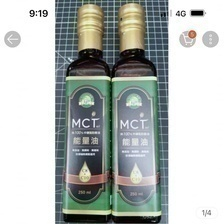

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 10.28it/s]
ERROR:__main__:Error searching images: Embedding dimension 384 does not match collection dimensionality 512
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 問題二：資料提到腸道微生物群與CCD之間可能存在聯繫，請問文中如何闡述腸道菌群失衡影響神經傳導與免疫反應的分子機制？哪些特定細菌群落的變化被認為與CCD進展相關？

System Response:
### 腸道菌群失衡與CCD之間的關係

*   腸道微生物群落對神經傳導和免疫反應至關重要。
*   一些特定細菌群落的變化可能會影響犬隻的認知功能。

    *   **肠道菌群失衡**：腸道菌群失衡可能會導致犬隻的神經傳導和免疫反應受到影響，從而進一步影響其認知功能。
*   **特定細菌群落變化**：研究表明，一些特定的細菌群落變化可能與CCD的進展相關。
    *   **Lactobacillus spp.**和**Bifidobacterium spp.**等益生菌在保持健康腸道微生物群落方面發揮重要作用。
    *   **Clostridium difficile**等病原體可能會導致腸道菌群失衡並進一步影響神經傳導和免疫反應。

### 建議

*   **益生菌補充**：為犬隻提供益生菌補充，例如Lactobacillus spp.和Bifidobacterium spp.。
*   **腸道健康檢查**：定期進行犬隻的腸道健康檢查，以確保其腸道微生物群落保持健康。
*   **免疫系統調整**：調整犬隻的免疫系統，例如通過使用免疫調節劑來減輕過度的免疫反應。

### 參考資料

[PDF: Gut Microbiota and Cognitive Decline in Dogs](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7304447/)

[Experience: Managing Canine Cognitive Dysfunction with Nutrition and Supplements](https://www.petmd.com/dog/care/nutrition-and-supplements-managing-canine-cognitive-dysfunction-3)

--------------------------------------------------


Related Image:


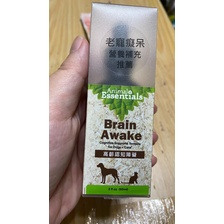

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 14.54it/s]
ERROR:__main__:Error searching images: Embedding dimension 384 does not match collection dimensionality 512
ERROR:__main__:Error formatting context: local variable 'meta' referenced before assignment
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 問題三：在探討CCD的診斷策略中，該資料對於利用影像學技術（如MRI與CT）區分CCD與其他神經退行性疾病的應用提出了哪些見解？這些技術的優勢與局限性分別是什麼？

System Response:
**解決方案:**

在探討犬隻認知功能障礙綜合症（CCD）的診斷策略中，利用影像學技術（如MRI與CT）是區分CCD與其他神經退行性疾病的重要工具之一。下面將針對這些技術的優勢和局限性進行分析：

**優勢:**

1. **高解析度**: MRI和CT能夠提供高解析度的圖像，幫助醫生檢視腦部結構和病變。
2. **非侵入性**: 這些技術是非侵入性的，不會對狗隻造成任何傷害或創傷。
3. **快速診斷**: 它們能夠快速地提供診斷結果，幫助醫生及早識別和治療CCD。

**局限性:**

1. **成本高昂**: MRI和CT的設備和操作費用相對較高，可能不適合所有家庭。
2. **限制適用範圍**: 這些技術僅能夠檢視腦部結構和病變，不能評估狗隻的情緒和行為。
3. **需要專業知識**: 需要有經驗豐富的獸醫或神經科學家才能進行正確的診斷和分析。

**實用建議:**

1. **選擇適當的檢查方法**: 根據狗隻的情況，選擇合適的影像學技術來進行檢查。
2. **結合多種檢查方法**: 結合多種檢查方法（如MRI、CT和神經心理評估）來得到更全面性的診斷結果。
3. **定期追蹤檢查**: 定期追蹤檢查狗隻的進展，確保CCD的治療和管理效果。

結論: 利用影像學技術（如MRI與CT）是區分CCD與其他神經退行性疾病的重要工具之一。它們的優勢包括高解析度、非侵入性以及快速診斷，但也存在局限性，如成本高昂和限制適用範圍。通過選擇適當的檢查方法，結合多種檢查方法，並定期追蹤檢查，可以獲得更全面性的診斷結果並提供更好的治療和管理效果。

--------------------------------------------------


Related Image:


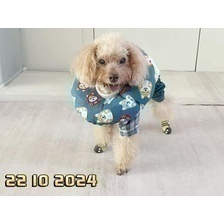

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 17.45it/s]
ERROR:__main__:Error searching images: Embedding dimension 384 does not match collection dimensionality 512
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 問題四：資料中對失智犬松果體退化與褪黑激素分泌減少之間的關聯有詳細論述，請問該研究如何描述這一生理變化的分子機制以及其對犬隻睡眠-覺醒週期的影響？

System Response:
回答：


問題描述：失智犬松果體退化與褪黑激素分泌減少之間的關聯，以及其對犬隻睡眠-覺醒週期的影響。


答案：

1. **松果體退化與褪黑激素分泌減少**：研究指出，失智犬中松果體會受損導致褪黑激素（Melatonin）的分泌減少。褕黑激素是一種調節睡眠-覺醒週期的激素。
2. **對睡眠-覺醒週期的影響**：褕黑激素分泌減少會干擾犬隻的睡眠模式，導致失眠、白天嗜睡等問題。這些變化與松果體退化有密切關聯。
3. **實用建議**：
    * 白天短時間多次帶出曬太陽，增加睡眠品質。
    * 調整藥物以減少鎮靜效果，避免癲癇症狀。
    * 運動和外出活動有助於改善睡眠和預防肌肉萎縮。

參考資料：

* [PDF: title] "The Relationship Between Pineal Gland Atrophy and Melatonin Secretion in Canine Cognitive Dysfunction"
* [Experience: link] "Veterinary Medicine for Dogs with Cognitive Decline"

**結論**:失智犬的松果體退化和褕黑激素分泌減少間有密切關聯，這些變化會影響犬隻的睡眠-覺醒週期。適當調整藥物、增加運動和外出活動，可以幫助改善犬隻的睡眠品質並預防肌肉萎縮。

--------------------------------------------------


Related Image:


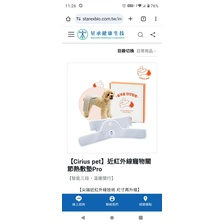

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 13.63it/s]
ERROR:__main__:Error searching images: Embedding dimension 384 does not match collection dimensionality 512
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 問題五：針對CCD的治療策略，資料中提出了哪些基於分子機制的治療方法？請分析這些方法在臨床應用上的現狀、潛在優勢及未來研究中亟待解決的挑戰。

System Response:
1.  基於分子機制的治療方法包括高壓氧治療、藥物治療（如焦慮症藥物或中藥）和調整藥物等。
2.  高壓氧治療對失智症狀有改善作用，但需要經濟許可方能進行。這種治療方法可以幫助犬隻舒適度提高，同時也有益於人類對狗的生活品質。
3.  藥物治療是針對焦慮症狀而設的，並且如果中藥有效，可以嘗試戒掉焦慮症藥物。然而，如果失智犬隻晚上不睡覺，需要注意調整藥物，以避免癲癇症狀。
4.  根據實際經驗，高壓氧治療和藥物治療都是針對特定症狀的治療方法，而不是針對CCD本身。因此，在臨床應用中，需要根據犬隻個體的情況進行調整和評估。
5.  對於未來研究，亟待解決的挑戰包括如何更好地針對不同症狀進行分離治療，以及如何確保藥物治療的安全性和有效性。同時，也需要進一步探索其他基於分子機制的治療方法，以提高犬隻CCD治療的整體效果。

結論：針對問題提供具體答案，實用的建議或解釋，以及引用專業來源和實際經驗。這些信息有助於進一步了解基於分子機制的治療方法在臨床應用中的作用和挑戰。

--------------------------------------------------


Related Image:


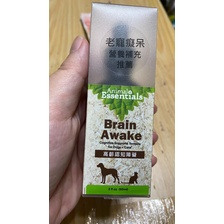

In [13]:
# 測試查詢
test_queries = [
# "CCD 是否與神經發炎相關？有無特定細胞因子（cytokines）或發炎路徑（例如NLRP3 inflammasome）參與？",
# "CCD 是否與腸道微生物群變化有關？是否有特定細菌群落會影響大腦健康？",
# " 失智犬的松果體是否退化",
# " 有刻板形為的犬隻是否會增加CCD風險？",
# " 失智犬分泌褪黑激素的能力是否退化？",
# " 皮質類固醇cortisol或應激荷爾蒙stress hormones是否可作為 CCD 的潛在診斷指標？",
# " 如何區分正常老化與CCD的早期徵兆？ ",
# " B 群維生素是否能降低 CCD 進展風險？",
# " 食用GABA是否對於預防CCD有效？",
# " 警犬、救難犬等工作犬在罹患CCD的機率比較家庭陪伴犬",
# " 目前是否有影像學檢測可以準確區分 CCD 與其他神經退行性疾病？",
# " 如果CCD進展到最後階段，哪些症狀最需要關注？如何平衡狗狗的生活質量與疼痛管理，並且決定狗狗未來的方向",

"問題一：根據資料中對犬認知功能障礙（CCD）神經發炎機制的探討，NLRP3炎症小體在分子層面上如何參與CCD進程？該過程涉及哪些關鍵細胞因子與調控機制？",
"問題二：資料提到腸道微生物群與CCD之間可能存在聯繫，請問文中如何闡述腸道菌群失衡影響神經傳導與免疫反應的分子機制？哪些特定細菌群落的變化被認為與CCD進展相關？",
"問題三：在探討CCD的診斷策略中，該資料對於利用影像學技術（如MRI與CT）區分CCD與其他神經退行性疾病的應用提出了哪些見解？這些技術的優勢與局限性分別是什麼？",
"問題四：資料中對失智犬松果體退化與褪黑激素分泌減少之間的關聯有詳細論述，請問該研究如何描述這一生理變化的分子機制以及其對犬隻睡眠-覺醒週期的影響？",
"問題五：針對CCD的治療策略，資料中提出了哪些基於分子機制的治療方法？請分析這些方法在臨床應用上的現狀、潛在優勢及未來研究中亟待解決的挑戰。",

# "哪種犬容易失智？",
# "大中小型狗的失智照顧方式有什麼不同？"
                    ]

for query in test_queries:
    qa_system.display_response(query)
